In [1]:
import scanpy as sc
import pandas as pd
adata_full= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_all_genes_log_normalised.h5ad') 
adata= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_hvg_only.h5ad') 

In [11]:
# --- CRITICAL: fix duplicated obs columns BEFORE any subsetting ---
if not adata.obs.columns.is_unique:
    print('duplicated columns may cause error')

In [12]:
# --- CRITICAL: fix duplicated obs columns BEFORE any subsetting ---
if not adata_full.obs.columns.is_unique:
    print('duplicated columns may cause error')

In [13]:
import pandas as pd

def add_metadata_to_obs(
    adata,
    df: pd.DataFrame,
    df_key: str,
    obs_key: str = None,
):
    """
    Merge EVERY column of `df` into `adata.obs` by matching
      df[df_key]  ↔  adata.obs[obs_key] (or adata.obs_names if obs_key is None).

    Keeps duplicates in df_key by dropping all but the first.
    Leaves adata.obs index untouched.
    """

    # 1. Sanity checks
    assert df_key in df.columns, f"{df_key!r} not in metadata DataFrame"
    if obs_key is not None:
        assert obs_key in adata.obs.columns, f"{obs_key!r} not in adata.obs"

    # 2. Deduplicate metadata on the key, keep only first
    df_unique = df.drop_duplicates(subset=[df_key], keep="first").copy()

    # 3. Build a lookup Series indexed by the key
    df_indexed = df_unique.set_index(df_key)

    # 4. Pick the “left” key from adata.obs
    if obs_key is None:
        # map from obs_names
        left_index = pd.Series(adata.obs_names, index=adata.obs_names, name=df_key)
    else:
        # map from an existing obs column
        left_index = adata.obs[obs_key].rename(df_key)

    # 5. For every column in df_indexed (including df_key itself), map into adata.obs
    for col in df_indexed.columns:
        adata.obs[col] = left_index.map(df_indexed[col])

    # 6. Report if anything expected went missing
    missing = adata.obs[df_indexed.columns].isna().any(axis=1).sum()
    if missing:
        print(f"⚠️  {missing} cells did not get full metadata from `{df_key}` join")

    return adata


In [14]:
published_anno= pd.read_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/old_annotations/published_annotations_bone_atlas.csv', index_col=0)
doublets= pd.read_csv('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/combined_scrublet_scores_filtered_bone_atlas.csv')
adata_celltypist= pd.read_csv('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/all_samples_predictions_filtered_bone_atlas.csv')
annotation_levels= pd.read_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/CellTypist_Hierarchy_Levels3_2_1.csv', index_col=0)

/tmp/ipykernel_1281489/446193315.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  published_anno= pd.read_csv('/nfs/team298/sm54/BoneAtlasProject/metadata/old_annotations/published_annotations_bone_atlas.csv', index_col=0)
/tmp/ipykernel_1281489/446193315.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  doublets= pd.read_csv('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/combined_scrublet_scores_filtered_bone_atlas.csv')


In [1]:
adata

NameError: name 'adata' is not defined

In [17]:
adata_full

AnnData object with n_obs × n_vars = 1566868 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_un

In [37]:
adata.obs['predicted_doublets_pval_filtered']=adata.obs['predicted_doublets_pval_filtered'].astype(str)
adata.obs['bh_pval_filtered']=adata.obs['bh_pval_filtered'].astype(str)
adata_full.obs['predicted_doublets_pval_filtered']=adata_full.obs['predicted_doublets_pval_filtered'].astype(str)
adata_full.obs['bh_pval_filtered']=adata_full.obs['bh_pval_filtered'].astype(str)

In [19]:
# Rename columns to use "_unfiltered" suffix
rename_dict = {
    'predicted_labels':             'predicted_labels_unfiltered',
    'over_clustering':              'over_clustering_unfiltered',
    'majority_voting':              'majority_voting_unfiltered',
    'predicted_labels_Level1':      'predicted_labels_Level1_unfiltered',
    'predicted_labels_Level2':      'predicted_labels_Level2_unfiltered',
    'majority_voting_Level1':       'majority_voting_Level1_unfiltered',
    'majority_voting_Level2':       'majority_voting_Level2_unfiltered',
}

# Apply renaming in-place
adata.obs.rename(columns=rename_dict, inplace=True)

# Optional: display updated columns to verify
print([col for col in adata.obs.columns if col.endswith('_unfiltered')])


['predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfiltered', 'predicted_doublets_pval_unfiltered']


In [20]:
# Apply renaming in-place
adata_full.obs.rename(columns=rename_dict, inplace=True)
print([col for col in adata_full.obs.columns if col.endswith('_unfiltered')])


['predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfiltered', 'predicted_doublets_pval_unfiltered']


In [21]:
add_metadata_to_obs(adata, adata_celltypist,   df_key='Cell_ID')


⚠️  211 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566868 × 3000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pred

In [22]:
add_metadata_to_obs(adata_full, adata_celltypist,   df_key='Cell_ID')


⚠️  211 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566868 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

In [23]:
# assume you already have:
#   annotation_levels: a pd.DataFrame with columns ["Level1","Level2","Level3"]
#   adata: your AnnData with obs cols "predicted_labels" and "majority_voting"

# 1) make the two mappings
lvl1_map = annotation_levels.set_index("Level3")["Level1"].to_dict()
lvl2_map = annotation_levels.set_index("Level3")["Level2"].to_dict()

# 2) apply to both columns
for src in ["predicted_labels", "majority_voting"]:
    adata.obs[f"{src}_Level1"] = adata.obs[src].map(lvl1_map)
    adata.obs[f"{src}_Level2"] = adata.obs[src].map(lvl2_map)

# 2) apply to both columns
for src in ["predicted_labels", "majority_voting"]:
    adata_full.obs[f"{src}_Level1"] = adata_full.obs[src].map(lvl1_map)
    adata_full.obs[f"{src}_Level2"] = adata_full.obs[src].map(lvl2_map)



In [24]:
(adata.obs['majority_voting_Level1'].value_counts())

majority_voting_Level1
Mesenchymal       802261
Stroma            359529
Haematopoietic    184365
Neural            150229
Erythroid          70150
Gonadal              117
Liver                  6
Name: count, dtype: int64

In [25]:
(adata_full.obs['majority_voting_Level1'].value_counts())

majority_voting_Level1
Mesenchymal       802261
Stroma            359529
Haematopoietic    184365
Neural            150229
Erythroid          70150
Gonadal              117
Liver                  6
Name: count, dtype: int64

In [26]:
(adata.obs['majority_voting_Level1_unfiltered'].value_counts())

majority_voting_Level1_unfiltered
Mesenchymal       796217
Stroma            350094
Haematopoietic    180778
Neural            160118
Erythroid          79661
Name: count, dtype: int64

In [26]:
add_metadata_to_obs(adata, published_anno,   df_key='Cell_ID')


⚠️  1502063 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566868 × 3000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pred

In [27]:
add_metadata_to_obs(adata_full, published_anno,   df_key='Cell_ID')


⚠️  1502063 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566868 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

In [29]:
add_metadata_to_obs(adata_full, doublets,   df_key='Cell_ID')


⚠️  17914 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566868 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

In [30]:
add_metadata_to_obs(adata, doublets,   df_key='Cell_ID')


⚠️  17914 cells did not get full metadata from `Cell_ID` join


AnnData object with n_obs × n_vars = 1566868 × 3000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pred

In [34]:
adata.obs['predicted_doublets_pval']=adata.obs['predicted_doublets_pval'].astype(str)
adata.obs['predicted_doublets']=adata.obs['predicted_doublets'].astype(str)
adata_full.obs['predicted_doublets_pval']=adata_full.obs['predicted_doublets_pval'].astype(str)
adata_full.obs['predicted_doublets']=adata_full.obs['predicted_doublets'].astype(str)

In [33]:
doublets

,Cell_ID,scrublet_score,predicted_doublets,scrublet_cluster_score,bh_pval,predicted_doublets_pval
0,CGCAATGTCAGCAAGA-HCA_BN_F12482363,0.002760,False,0.001950,0.681097,False
1,TAATCACCAATTGACT-HCA_BN_F12482363,0.004377,True,0.001950,0.681097,False
2,CAAGTAACATGACTAT-HCA_BN_F12482363,0.001950,False,0.001950,0.681097,False
3,AAAGCCGCATGTTGCA-HCA_BN_F12482363,0.001463,False,0.001301,0.728714,False
4,TGGCGGTTCTCCTCAA-HCA_BN_F12482363,0.004377,True,0.004377,0.681097,False
...,...,...,...,...,...,...
1579120,ACCCACTCATCGATGT-5478STDY7850149,0.016807,False,0.022009,0.845764,False
1579121,ACTTACTTCCTGTACC-5478STDY7850149,0.011678,False,0.018001,0.845764,False
1579122,CTCTAATCAAGTAATG-5478STDY7850149,0.008368,False,0.010366,0.850723,False
1579123,AGAGCGACACATCCGG-5478STDY7850149,0.017396,False,0.072088,0.434569,False


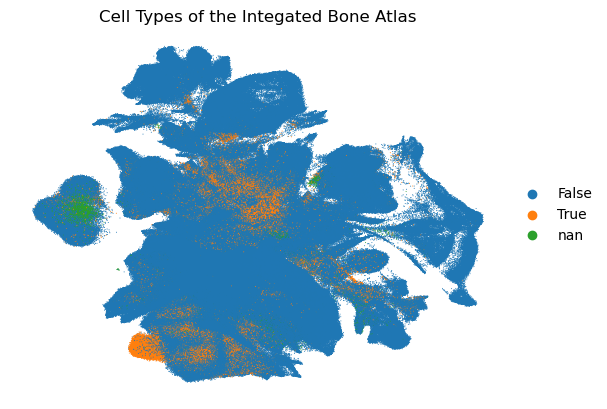

In [36]:
import scanpy as sc

sc.pl.umap(
    adata, 
    color='predicted_doublets', 
    size=2,               # Increase point size for better visibility
    legend_loc='right margin',  # Or 'right margin' if you want a separate legend
    frameon=False,
    title='Cell Types of the Integated Bone Atlas'
              # High resolution
)


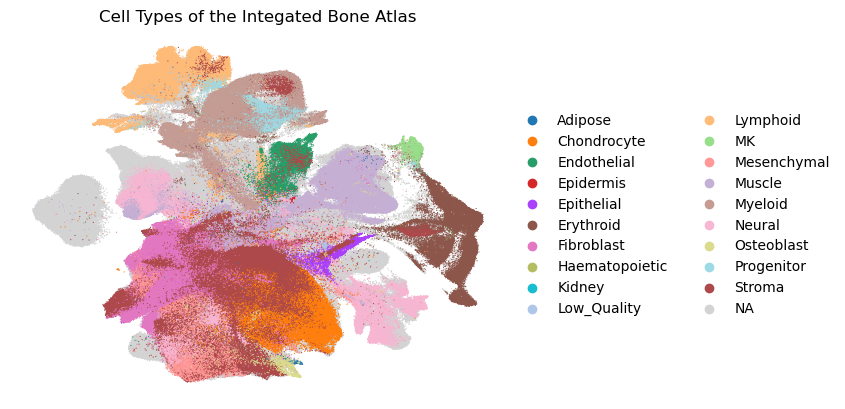

In [37]:
import scanpy as sc

sc.pl.umap(
    adata, 
    color='published_anno_level2', 
    size=3,               # Increase point size for better visibility
    legend_loc='right margin',  # Or 'right margin' if you want a separate legend
    frameon=False,
    title='Cell Types of the Integated Bone Atlas'
              # High resolution
)


In [38]:
adata.write_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_hvg_label_propagation.h5ad') 


In [39]:
adata_full.write_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_all_genes_log_normalised.h5ad') 
adata.write_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_hvg_only.h5ad') 



In [40]:
# --- CRITICAL: fix duplicated obs columns BEFORE any subsetting ---
if not adata.obs.columns.is_unique:
    print('duplicated columns may cause error')

In [41]:
# --- CRITICAL: fix duplicated obs columns BEFORE any subsetting ---
if not adata_full.obs.columns.is_unique:
    print('duplicated columns may cause error')